# Simulation of Covid19 spread

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
from modsim import *     # source: https://github.com/AllenDowney/ModSimPy

## Loading data to compare simulation with

Source: https://github.com/datasets/covid-19

In [2]:
filepath_CSV = "C:/Users/julia.baldauf/Desktop/Julia/Scripts/covid-19/data/time-series-19-covid-combined.csv"
covid19_data = pd.read_csv(filepath_CSV, delimiter=',')

getting the data for Germany from the day the first sick person is reported

In [3]:
country = 'Germany'
covid19_data_mask = covid19_data.apply(lambda row: row['Country/Region'] == country and row['Confirmed'] > 0, axis=1)
covid19_data_country = covid19_data[covid19_data_mask].reset_index()

## Helper functions for the simulation

In [4]:
def plot_results(results, system):
    """Plot the results 
    """
    #plot(results.H, '--', label='Gesund simuliert')
    plot(results.C/system.population, '--', label='Confirmed simuliert', color = 'red')
    plot(results.R/system.population, '--', label='Recovered simuliert', color = 'green')
    plot(results.D/system.population, '--', label='Deaths simuliert', color = 'black')
    plot(covid19_data_country['Confirmed']/system.population, label='Confirmed', color = 'red')
    plot(covid19_data_country['Recovered']/system.population, label='Recovered', color = 'green')
    plot(covid19_data_country['Deaths']/system.population, label='Deaths', color = 'black')
    decorate(xlabel='Zeit (Tage)',
             ylabel='Anteil der Population')
    plt.show

In [14]:
def make_system_action():
    """Make a system object for the model.
    
    healthy: Number of healthy people
    confirmed: Number of confirmed cases
    recovered: Number of recovered people
    deaths: Number of people that died
    t0: start
    t_end: simulation end
    
    returns: System object
    """
    population = 80000001
    confirmed = 1
    healthy = population - confirmed
    recovered=0
    deaths=0
    init = State(H=healthy, C=confirmed, R=recovered, D=deaths)

    N_intensivcare_beds = 20000
    p_need_hospital = 0.0001
    
    t0 = 0
    t_end = len(covid19_data_country) # in Tagen die von der Simulation vorhanden sind
    
    return System(init=init, t0=t0, t_end=t_end, population=population,
                  N_intensivcare_beds= N_intensivcare_beds, p_need_hospital=p_need_hospital)

In [15]:
def run_simulation(system, update_func, action_parameters):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system, action_parameters, frame)
    
    return frame

In [16]:
def calculate_probabilities(parameters, system):
    p_infection =  parameters['p_0'] * parameters['people_density'] * parameters['infection_cross_section'] / (parameters['infection_days']  * system.population)
    p_recovery = 1 / parameters['recovery_days'] 
    return p_infection, p_recovery

The update function calculates the new state for a given time t and applies the probablities aplying at that time. At the moment one can pass on one action, for example social distancing which will reduce the people density.

In [29]:
def update_func_action(state, t, system, action_parameters, frame):
    """Update the model
    
    state: State with variables H=healthy, C=confirmed, R=recovered, D=deaths
    t: time step
    system: System with variables t0=t0, t_end=t_end, population=population,N_intensivcare_beds: N_intensivcare_beds 
    
    returns: State object
    """    
    h, c, r, d = state
    
    if (c+h+r+d) - system.population > 0.001:
        print('Hmmmm haben wir Einwohner verloren oder gewonnen? %s' % str(c+h+r+d))
    
    if t > action_parameters['action1']['t_start']*(system.t_end-system.t0) and t < action_parameters['action1']['t_end']*(system.t_end-system.t0):
        p_infection, p_recovery = calculate_probabilities(action_parameters['action1'], system)
        delta_recovered = p_recovery * c # (frame.loc[t - action_parameters['no_action']['recovery_days']]['C']-frame.loc[t - action_parameters['no_action']['recovery_days'] -1]['C'])
        
    else:
        p_infection, p_recovery = calculate_probabilities(action_parameters['no_action'], system)
        if t > action_parameters['no_action']['recovery_days']:
            delta_recovered = p_recovery * c # (frame.loc[t - action_parameters['no_action']['recovery_days']]['C'] - frame.loc[t - action_parameters['no_action']['recovery_days'] -1]['C'])
        else:
            delta_recovered = p_recovery * c
        
    delta_confirmed = p_infection * c * h 
    if system.p_need_hospital *c > system.N_intensivcare_beds:
        delta_deaths =  system.probability_need_hospital * c
    else:
        delta_deaths = action_parameters['no_action']['mortality_rate'] * c
        
    
    h -= delta_confirmed
    c += delta_confirmed - delta_recovered - delta_deaths
    r += delta_recovered
    d += delta_deaths
    
    return State(H=h, C=c, R=r, D=d)

## Defining parameters for the model

In [116]:
action_parameters = {'no_action' :
                            {
                            'p_0' : 0.21,                        
                            'infection_days' : 1.8,             
                            'infection_cross_section' : 4.2,    
                            'people_density' : 1,           
                            'recovery_days' : 4,              
                            'mortality_rate' : 0.004,          
                            },
                     'action1' :
                             {
                            'p_0' : 0.3,     
                            'infection_days' : 3,      
                            'infection_cross_section' : 4,
                            'people_density' : 0.2,   
                            'recovery_days' : 10,    
                            't_start' : 0.5, # fraction of total simulation duration when action starts
                            't_end' : 1    # fraction of total simulation duration when action ends, 1 = until the end
                            }
                        }

## Running the simulation

In [117]:
system = make_system_action()

In [118]:
results = run_simulation(system, update_func_action, action_parameters)

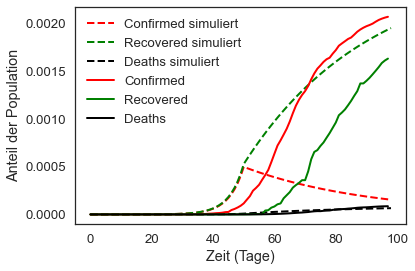

In [119]:
plot_results(results, system)

In [34]:
@interact_manual
def pltslider(p_0_0=0.3, infection_days_0=2, infection_cross_section_0= 2, people_density_0= 0.5, 
              recovery_days_0=10, p_0_1=0.3, infection_days_1= 3, infection_cross_section_1=1, 
              people_density_1=0.2, recovery_days_1 = 10, t_start_1=0.5, t_end_1=1):
    action_parameters = {'no_action' :
                            {
                            'p_0' : p_0_0,     
                            'infection_days' : infection_days_0,       
                            'infection_cross_section' : infection_cross_section_0, 
                            'people_density' : people_density_0,  
                            'recovery_days' : recovery_days_0,   
                            'mortality_rate' : 0.004,     
                            },
                     'action1' :
                             {
                            'p_0' : p_0_1,     
                            'infection_days' : infection_days_1,       
                            'infection_cross_section' : infection_cross_section_1,    
                            'people_density' : people_density_1,  
                            'recovery_days' : recovery_days_1,   
                            't_start' : t_start_1, # fraction of total simulation duration when action starts
                            't_end' : t_end_1      # fraction of total simulation duration when action ends, 1 = until the end
                            }
                        }
    system = make_system_action()
    results = run_simulation(system, update_func_action, action_parameters)
    return plot_results(results, system)

interactive(children=(FloatSlider(value=0.3, description='p_0_0', max=0.8999999999999999, min=-0.3), IntSlider…

In [121]:
@interact
def show_articles_more_than(column='Confirmed', x=50):
    return covid19_data_country.loc[x:x+10]

interactive(children=(Text(value='Confirmed', description='column'), IntSlider(value=50, description='x', max=…